In [6]:
!pip install pyathena
!pip install xgboost
!pip install pyarrow
!pip install s3fs

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 157.5 MB 22 kB/s s eta 0:00:01   |█▏                              | 5.5 MB 10.7 MB/s eta 0:00:15     |█████████▍                      | 46.3 MB 10.7 MB/s eta 0:00:11     |████████████████                | 78.3 MB 79.1 MB/s eta 0:00:02��█████████████▉    | 137.2 MB 72.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import pyarrow.parquet as pq
import s3fs
fs = s3fs.S3FileSystem()

In [66]:
dataset = pq.ParquetDataset('s3://datalake-curated-datasets-907317471167-us-east-1-pjkrtzr/year=2021', filesystem=fs)
table = dataset.read()
df = table.to_pandas()
df = df.sort_values(['unit_number', 'cycle'])

In [4]:
df.head()

,filename,unit_number,failure_cycle,cycle,op_1,op_2,op_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,...,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,month,day,hour
19204,train_FD001.txt,1,191,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,1,5,19
60712,train_FD004.txt,1,320,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,...,9.3335,0.02,330,2212,100.0,10.62,6.3670,1,5,19
65088,train_FD002.txt,1,148,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,...,9.3461,0.02,334,2223,100.0,14.73,8.8071,1,5,19
155602,train_FD003.txt,1,258,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,...,8.4246,0.03,391,2388,100.0,39.11,23.3537,1,5,19
19205,train_FD001.txt,1,190,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,1,5,19


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

In [16]:
!aws s3 cp s3://datalake-published-data-907317471167-us-east-1-pjkrtzr/sagemaker/cmapss-xgboost/hyper-xgboost/hyper-cmapss-2021-01-07-16-04-50-409-07f98126/output/model.tar.gz .

!tar xvzf model.tar.gz

In [18]:
import pickle as pkl
with open("xgboost-model", "rb") as f:
    booster = pkl.load(f)   

In [19]:
features = ['cycle', 'op_1', 'op_2',
       'op_3', 'sensor_measurement_1', 'sensor_measurement_2',
       'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_5',
       'sensor_measurement_6', 'sensor_measurement_7', 'sensor_measurement_8',
       'sensor_measurement_9', 'sensor_measurement_10',
       'sensor_measurement_11', 'sensor_measurement_12',
       'sensor_measurement_13', 'sensor_measurement_14',
       'sensor_measurement_15', 'sensor_measurement_16',
       'sensor_measurement_17', 'sensor_measurement_18',
       'sensor_measurement_19', 'sensor_measurement_20',
       'sensor_measurement_21']

In [21]:
is_train = df.unit_number % 3 != 0
is_test = df.unit_number % 3 == 0

In [64]:
x_train, x_test = df.loc[is_train, features  + ['filename']], df.loc[is_test, features + ['filename']]

y_train, y_test = df.loc[is_train, 'failure_cycle'],  df.loc[is_test, 'failure_cycle']

In [112]:
from sklearn.metrics import mean_squared_error

In [49]:
residuals = y_test.values - booster.predict(xgb.DMatrix(x_test[features].values))

In [116]:
mean_squared_error(y_test.values, booster.predict(xgb.DMatrix(x_test[features].values)), squared=False)

44.36013601663794

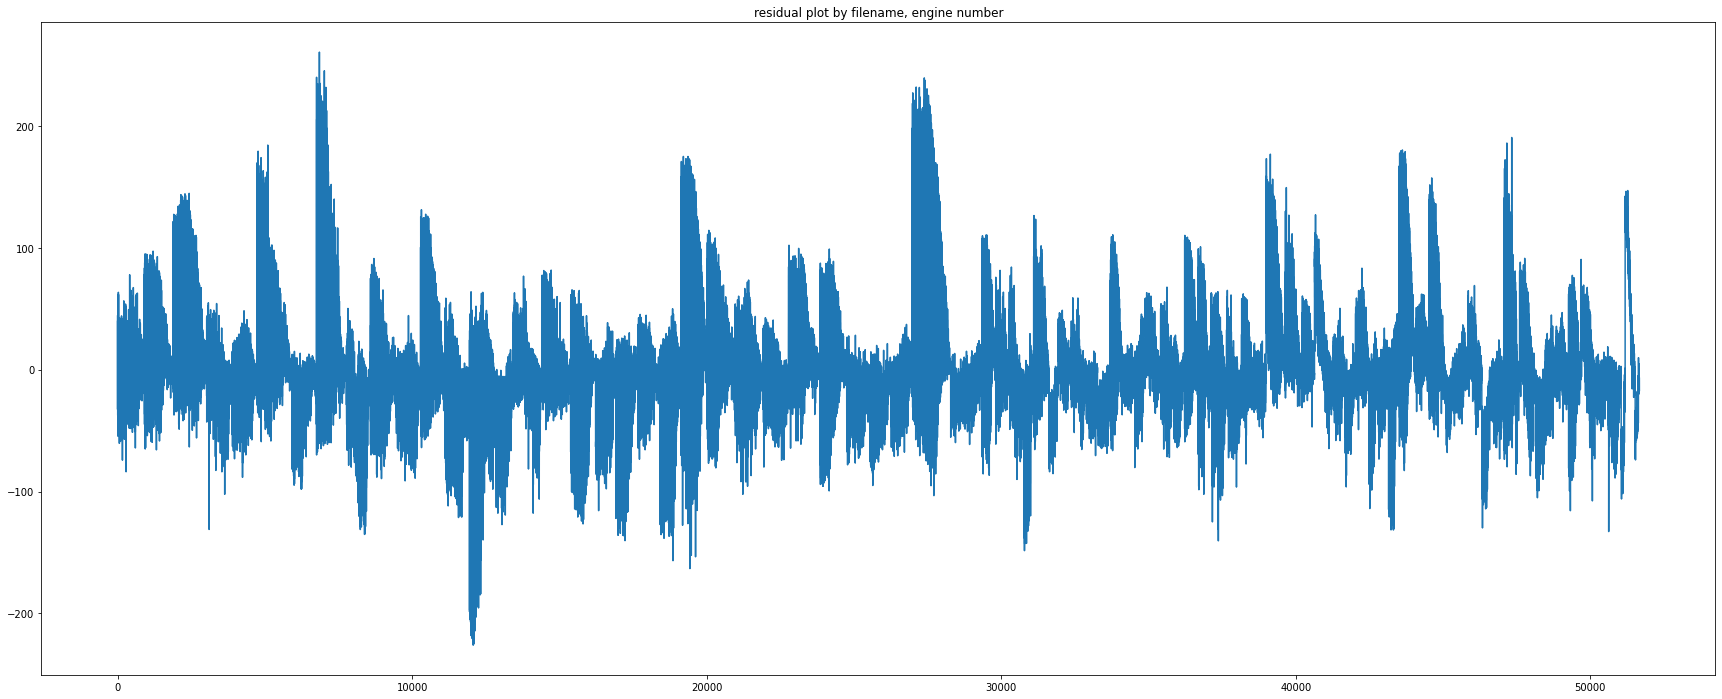

In [50]:
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(residuals)
_ = ax.set_title('residual plot by filename, engine number')

In [51]:
from matplotlib.colors import ListedColormap as lcm
labels, _ = df.loc[y_test.index, 'filename'].pipe(pd.factorize)
colours = ['red','orange','blue','green']

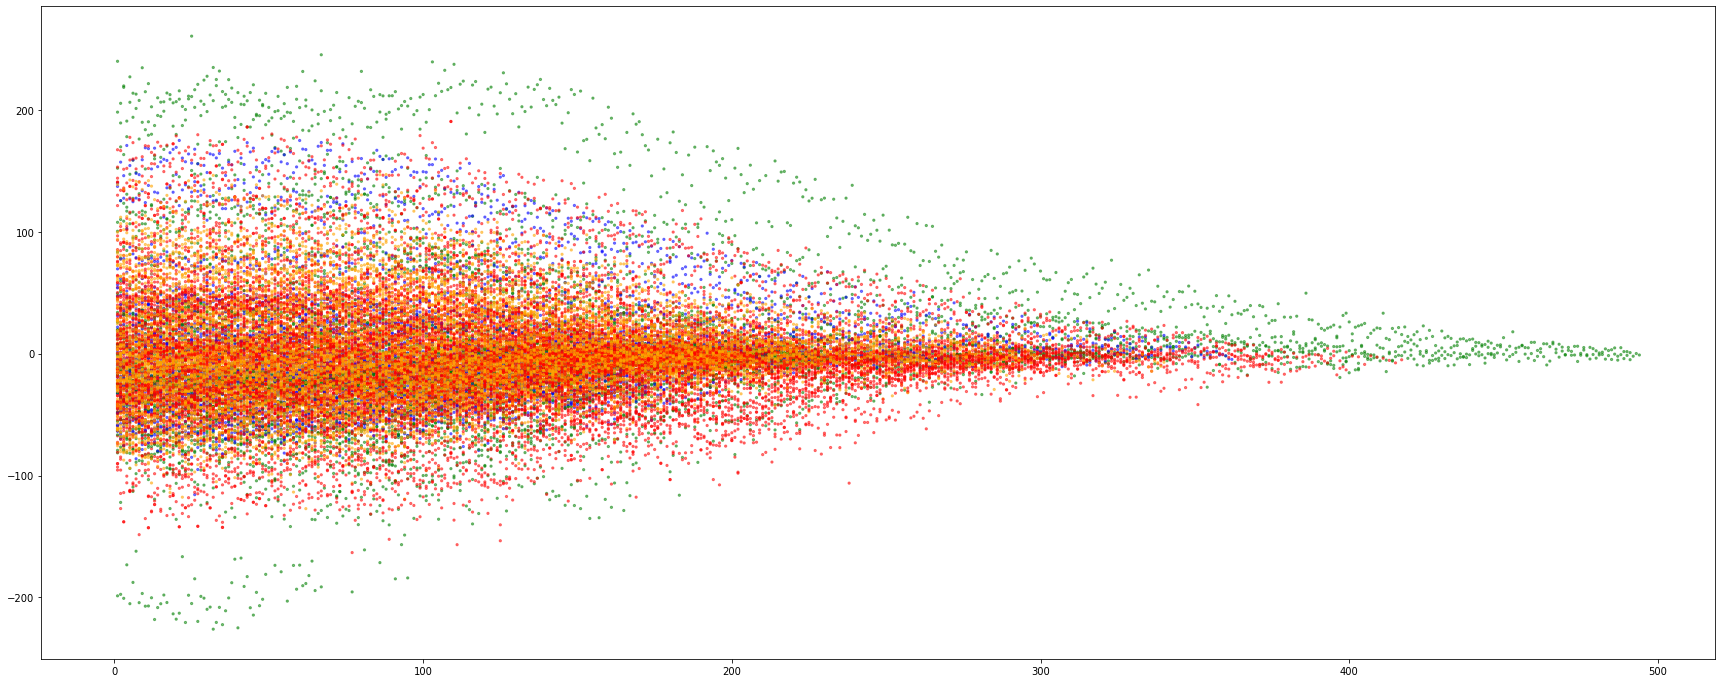

In [52]:
fig, ax = plt.subplots(figsize=(30, 12))
ax.scatter(df.loc[y_test.index, 'cycle'], residuals, c=labels, cmap=lcm(colours), s=5, alpha=.5)

In [103]:
x_test['residual'] = residuals

In [55]:
x_test.groupby('filename').residual.describe()

,count,mean,std,min,25%,50%,75%,max
filename,,,,,,,,
train_FD001.txt,6608.0,-0.628722,41.703216,-115.709702,-25.399927,-4.979549,10.563948,175.004593
train_FD002.txt,17506.0,-2.387850,34.093822,-127.192123,-22.189165,-4.812390,11.121140,147.016792
train_FD003.txt,8098.0,3.876181,62.486405,-226.096405,-25.879181,-3.090282,21.385916,260.607513
train_FD004.txt,19454.0,-2.332206,44.131340,-163.258270,-26.639145,-4.461285,15.991688,190.555252


In [60]:
! cat /home/ec2-user/SageMaker/aws-bb-cmapss/data/test_FD001.txt | cut -d ' ' -f2- > cmapss.test.1
! cat /home/ec2-user/SageMaker/aws-bb-cmapss/data/test_FD002.txt | cut -d ' ' -f2- > cmapss.test.2
! cat /home/ec2-user/SageMaker/aws-bb-cmapss/data/test_FD003.txt | cut -d ' ' -f2- > cmapss.test.3
! cat /home/ec2-user/SageMaker/aws-bb-cmapss/data/test_FD004.txt | cut -d ' ' -f2- > cmapss.test.4

In [108]:
all_test_data = []
for i in range(1, 5):
    filename = f'cmapss.test.{i}'
    test_file_name = f'test_FD00{i}.txt'
    test_rul_name = f'RUL_FD00{i}.txt'
    test_data = pd.read_csv(f"/home/ec2-user/SageMaker/aws-bb-cmapss/data/{test_file_name}", header=None, delimiter=' ')

    labels = pd.read_csv(f"/home/ec2-user/SageMaker/aws-bb-cmapss/data/{test_rul_name}", names=['remaining_cycles'])
    labels.index += 1
    labels = labels.reset_index()
    labels = labels.rename(columns={'index' : 0})
    labels = test_data.groupby(0)[1].max().reset_index().merge(labels, left_on=0, right_on=0)
    labels['max_cycles'] = labels[1] + labels['remaining_cycles']

    test_data = test_data.merge(labels[[0, 'max_cycles']], left_on=0, right_on=0)

    test_data['RUL'] = test_data['max_cycles'] - test_data[1]
    test_data['filename'] = filename
    all_test_data.append(test_data)

all_test_data_df = pd.concat(all_test_data)

In [109]:
residual_test = all_test_data_df.RUL.values - booster.predict(xgb.DMatrix(all_test_data_df.drop(columns=[0, 26, 27, 'max_cycles', 'RUL', 'filename']).values))

In [115]:
mean_squared_error(all_test_data_df.RUL.values, booster.predict(xgb.DMatrix(all_test_data_df.drop(columns=[0, 26, 27, 'max_cycles', 'RUL', 'filename']).values)), squared=False)

57.709556087846885

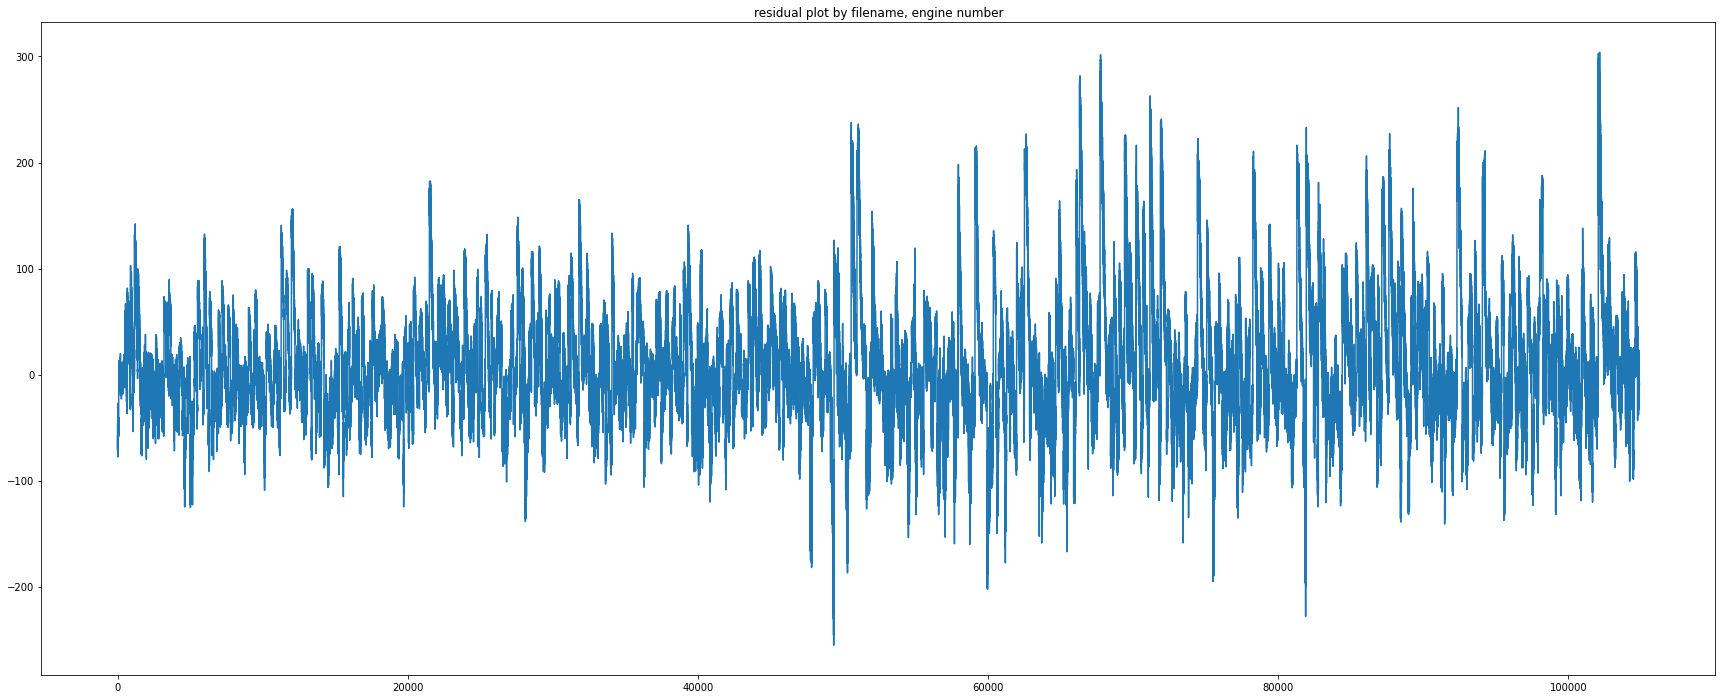

In [80]:
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(residual_test)
_ = ax.set_title('residual plot by filename, engine number')

In [81]:
all_test_data_df['residual'] = residual_test

In [84]:
all_test_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,max_cycles,RUL,filename,residual
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388,100.0,38.86,23.3735,NaN,NaN,143,142,cmapss.test.1,-46.637024
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388,100.0,39.02,23.3916,NaN,NaN,143,141,cmapss.test.1,-60.858078
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388,100.0,39.08,23.4166,NaN,NaN,143,140,cmapss.test.1,-58.174103
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388,100.0,39.00,23.3737,NaN,NaN,143,139,cmapss.test.1,-58.611984
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388,100.0,38.99,23.4130,NaN,NaN,143,138,cmapss.test.1,-66.911758


In [101]:
buckets, bins = pd.qcut(x_test.cycle, 10, precision=0, retbins=True)

# Futher comparisons of the data reveal a fact which we are aware of and which explains the reason for higher errors on the test set
* the test files (all_test_data_df) are truncated at some point prior to the engine failure, where are the train data (x_test) are upto and including the final cycle.
Considering the distribution of errors on the scatter above this provides fewer low error (late cycle) prediction in the test data which would pull down our average error rate.
Looking at the distribution of cycle across each of the files we can see the train data has larger dispertion
* the training data upper quartile starts at [152, 155, 193.75 and 180] cycles
* the test data upper quartile starts at [113, 119, 149 and 155] cycles


In [121]:
x_test.groupby(['filename']).cycle.describe()

,count,mean,std,min,25%,50%,75%,max
filename,,,,,,,,
train_FD001.txt,6608.0,106.867736,69.710392,1.0,51.0,101.0,152.00,362.0
train_FD002.txt,17506.0,106.889181,66.943381,1.0,51.0,102.0,155.00,340.0
train_FD003.txt,8098.0,142.325142,103.378154,1.0,63.0,125.0,193.75,494.0
train_FD004.txt,19454.0,126.601213,83.612747,1.0,59.0,117.0,180.00,417.0


In [120]:
all_test_data_df.groupby(['filename'])[1].describe()

,count,mean,std,min,25%,50%,75%,max
filename,,,,,,,,
cmapss.test.1,13096.0,76.836515,53.057749,1.0,33.0,69.0,113.0,303.0
cmapss.test.2,33991.0,81.223647,58.892845,1.0,34.0,70.0,119.0,367.0
cmapss.test.3,16596.0,105.999518,83.286900,1.0,42.0,87.0,149.0,475.0
cmapss.test.4,41214.0,108.739094,83.717459,1.0,43.0,91.0,155.0,486.0


# How do residuals vary across the train/ test

In [104]:
x_test.groupby(['filename',buckets]).residual.describe()

count       mean        std         min  \
filename        cycle                                                      
train_FD001.txt (0.0, 22.0]      726.0  -2.504561  50.789281  -86.244019   
                (22.0, 44.0]     726.0  -3.755982  50.656662 -115.709702   
                (44.0, 66.0]     726.0  -4.321798  50.130904  -88.229858   
                (66.0, 88.0]     726.0  -3.666177  47.859289  -83.804855   
                (88.0, 110.0]    726.0  -3.702890  44.198749  -69.713692   
                (110.0, 133.0]   754.0  -1.152965  38.874536  -79.414566   
                (133.0, 156.0]   705.0   0.305408  32.445708  -63.428772   
                (156.0, 183.0]   637.0   2.831494  28.467537  -58.045792   
                (183.0, 226.0]   537.0   8.049312  22.698423  -36.912132   
                (226.0, 494.0]   345.0   9.872488  14.305110  -11.570721   
train_FD002.txt (0.0, 22.0]     1892.0  -3.379630  43.861788 -117.789108   
                (22.0, 44.0]    1892.0  -3.787235  42.764452 -105.122421   
                (44.0, 66.0]    1892.0  -3.623476  42.160388 -127.192123   
                (66.0, 88.0]    1892.0  -4.294027  40.546853 -106.112152   
                (88.0, 110.0]   1892.0  -2.775645  37.417924 -119.322372   
                (110.0, 133.0]  1974.0  -2.439496  31.484923  -90.092560   
                (133.0, 156.0]  1845.0  -1.671300  24.668291  -71.997299   
                (156.0, 183.0]  1835.0  -0.503050  18.568626  -70.537537   
                (183.0, 226.0]  1579.0   0.421674  13.489835  -56.354706   
                (226.0, 494.0]   813.0   0.179374  10.830035  -37.054092   
train_FD003.txt (0.0, 22.0]      715.0   1.405239  82.684349 -218.186340   
                (22.0, 44.0]     715.0   0.881188  84.169375 -226.096405   
                (44.0, 66.0]     715.0   0.555060  79.966932 -214.549561   
                (66.0, 88.0]     715.0   0.775917  77.009338 -195.553711   
                (88.0, 110.0]    715.0  -0.480452  70.564215 -184.827423   
                (110.0, 133.0]   747.0   0.900544  61.744840 -139.748413   
                (133.0, 156.0]   737.0   1.559486  55.121857 -135.229279   
                (156.0, 183.0]   772.0   4.150465  46.893530 -134.661041   
                (183.0, 226.0]   857.0   8.758735  41.360778  -89.223892   
                (226.0, 494.0]  1410.0  11.782943  25.574665  -40.207283   
train_FD004.txt (0.0, 22.0]     1848.0   1.085215  56.994532 -148.551788   
                (22.0, 44.0]    1848.0  -0.442039  56.360199 -142.576538   
                (44.0, 66.0]    1829.0  -0.469235  53.472335 -132.643524   
                (66.0, 88.0]    1826.0  -2.348534  52.763904 -163.258270   
                (88.0, 110.0]   1826.0  -1.221774  50.255498 -152.362183   
                (110.0, 133.0]  1910.0  -1.429512  44.750493 -156.774826   
                (133.0, 156.0]  1866.0  -3.429129  37.340699 -121.004807   
                (156.0, 183.0]  1872.0  -4.869862  33.073220 -117.772827   
                (183.0, 226.0]  2030.0  -6.390596  29.408362 -107.694397   
                (226.0, 494.0]  2599.0  -3.063986  17.442081 -106.255951   

                                      25%        50%        75%         max  
filename        cycle                                                        
train_FD001.txt (0.0, 22.0]    -35.661686 -13.136742  16.097553  175.004593  
                (22.0, 44.0]   -36.211971 -15.256157  13.969833  173.169632  
                (44.0, 66.0]   -35.897781 -15.830536  12.547562  174.960602  
                (66.0, 88.0]   -33.549446 -15.542778  10.791906  173.310860  
                (88.0, 110.0]  -30.358004 -14.475109   8.751095  160.703506  
                (110.0, 133.0] -23.152164  -7.689329   4.784771  156.172768  
                (133.0, 156.0] -15.390663  -3.736670   5.717579  125.682098  
                (156.0, 183.0] -10.312904  -0.793730   7.015697  110.830215  
                (183.0, 226.0]  -4.002255   0.353560  11.885

In [105]:
all_test_data_df.groupby(['filename', pd.cut(all_test_data_df[1], bins)]).residual.describe()

count       mean        std         min  \
filename      1                                                          
cmapss.test.1 (1.0, 22.0]     2100.0   3.520735  44.656605 -125.288116   
              (22.0, 44.0]    2165.0   3.442535  43.878569 -124.837585   
              (44.0, 66.0]    1996.0   5.539272  43.434743 -124.005646   
              (66.0, 88.0]    1763.0   8.490756  42.294289  -86.309799   
              (88.0, 110.0]   1557.0   8.280883  40.722240  -89.006210   
              (110.0, 133.0]  1384.0   7.762673  37.190255  -80.164001   
              (133.0, 156.0]   955.0   6.500854  31.985700  -60.163895   
              (156.0, 183.0]   611.0   5.642109  27.468518  -57.098763   
              (183.0, 226.5]   356.0  10.824724  24.113555  -38.132217   
              (226.5, 494.0]   109.0   4.466225  21.191497  -28.535103   
cmapss.test.2 (1.0, 22.0]     5438.0   5.858601  47.666633 -135.746918   
              (22.0, 44.0]    5514.0   6.582082  47.408448 -138.485275   
              (44.0, 66.0]    5009.0   9.755159  46.665680 -114.380569   
              (66.0, 88.0]    4277.0  11.602093  46.089158 -135.819489   
              (88.0, 110.0]   3705.0  12.355930  43.160384 -114.929489   
              (110.0, 133.0]  3335.0  11.621051  36.797735  -98.788689   
              (133.0, 156.0]  2581.0  10.831543  30.121543  -64.782944   
              (156.0, 183.0]  1846.0  11.397143  25.684043  -64.752716   
              (183.0, 226.5]  1339.0  12.988834  20.518929  -47.086792   
              (226.5, 494.0]   688.0   9.299476  15.737585  -42.023972   
cmapss.test.3 (1.0, 22.0]     2100.0  -5.436495  69.236693 -196.868713   
              (22.0, 44.0]    2191.0  -6.088853  68.747860 -202.530945   
              (44.0, 66.0]    2098.0  -4.547773  68.637975 -188.374298   
              (66.0, 88.0]    1927.0  -5.198087  70.722780 -225.840942   
              (88.0, 110.0]   1713.0   0.030292  71.566194 -255.108856   
              (110.0, 133.0]  1480.0   4.998880  69.133659 -190.394592   
              (133.0, 156.0]  1198.0   7.737704  61.087120 -171.162567   
              (156.0, 183.0]  1094.0   5.341505  54.892290 -145.054993   
              (183.0, 226.5]  1140.0  10.485861  50.855737 -114.906097   
              (226.5, 494.0]  1555.0  18.780771  31.474184  -45.905762   
cmapss.test.4 (1.0, 22.0]     5197.0  13.014354  71.949132 -228.039459   
              (22.0, 44.0]    5202.0  13.640582  71.297904 -199.115082   
              (44.0, 66.0]    4939.0  14.328683  71.954203 -181.160828   
              (66.0, 88.0]    4549.0  16.819457  69.886478 -189.924591   
              (88.0, 110.0]   4160.0  18.899573  69.416224 -155.837006   
              (110.0, 133.0]  3688.0  20.331775  68.591487 -158.725525   
              (133.0, 156.0]  3091.0  20.119571  65.437487 -167.124176   
              (156.0, 183.0]  2905.0  18.094720  63.204204 -140.929749   
              (183.0, 226.5]  3158.0  18.936176  57.048878 -135.915100   
              (226.5, 494.0]  4077.0  23.060754  36.941650  -70.808640   

                                    25%        50%        75%         max  
filename      1                                                            
cmapss.test.1 (1.0, 22.0]    -25.922104  -4.356697  25.610508  150.095718  
              (22.0, 44.0]   -25.752701  -4.136856  26.616257  149.234985  
              (44.0, 66.0]   -23.238945  -2.878273  29.806156  155.589104  
              (66.0, 88.0]   -20.548023   0.525902  31.212120  152.160652  
              (88.0, 110.0]  -18.366188  -0.360016  33.614380  156.355827  
              (110.0, 133.0] -17.367428   1.915558  29.883945  140.861984  
              (133.0, 156.0] -16.133802   0.081562  22.494577  123.967819  
              (156.0, 183.0] -11.588488  -0.833815  13.254990   99.660904  
              (183.0, 226.5]  -4.525483   2.798200  23.428264   87.730965  
              (226.5, 494.0]  -9.470699  -1.635033   8.514038   60.917480  
cmapss.tes

### To confirm our hypothesis for the discrepencies in eval vs test performance we can truncate the eval data from the train files similarly to the test files and see what our error rate looks like
The number of cycles an engine lasted for on eval vs test is distributed similarly

In [142]:
all_test_data_df.loc[all_test_data_df[1] == 1,'RUL'].add(1).describe()

count    707.000000
mean     229.806223
std       69.589798
min      126.000000
25%      180.500000
50%      215.000000
75%      261.000000
max      554.000000
Name: RUL, dtype: float64

In [141]:
y_test.loc[x_test['cycle'] == 1].add(1).describe()

count    236.000000
mean     221.190678
std       66.340464
min      128.000000
25%      176.750000
50%      202.000000
75%      245.250000
max      494.000000
Name: failure_cycle, dtype: float64

The observed cycles for the test set is much lower

In [137]:
all_test_data_df.groupby(['filename', 0])[1].max().describe()

count    707.000000
mean     148.369165
std       78.471162
min       19.000000
25%       88.500000
50%      142.000000
75%      187.000000
max      486.000000
Name: 1, dtype: float64

A crude way to validate our hypothesis is to truncate the eval data at the median of the observed cycles on the test data 142 
And this does give us a higher error
We could do more investigation however I'm comfortable that we've explained a significant difference is not down to our model overfitting but rather distributional differences between eval and test sets

In [144]:
filt = x_test.cycle < 142

In [146]:
mean_squared_error(y_test[filt].values, 
                   booster.predict(xgb.DMatrix(x_test.loc[filt, features].values)), 
                   squared=False)

51.15290596835779

# Feature Processing 
Our model as is doesn't use any previous cycle information to inform our current predictions, this seems like we're missing out on significant valuable information to leverage for predictions. The variation through time of different features could well help us improve our predictions.
* One idea could be to provide a smoothed sensor measurement so the model can avoid over reacting to noising variations and has a notion of where the sensormeasurement has been over time
* exponential moving averages are an excellent way to do this, we can see the smoothed (yellow) line below provides a less noisy picture of the sensor measurement
If this approach, including sensor measurement history, provides more information then our model should have better accuracy.

In [147]:
sensor_cols = [c for c in df.columns if 'sensor' in c]

In [37]:
df["ewm_sm11"] = df.groupby(['filename', 'unit_number'])['sensor_measurement_11'].apply(lambda d: d.ewm(alpha=.2).mean())

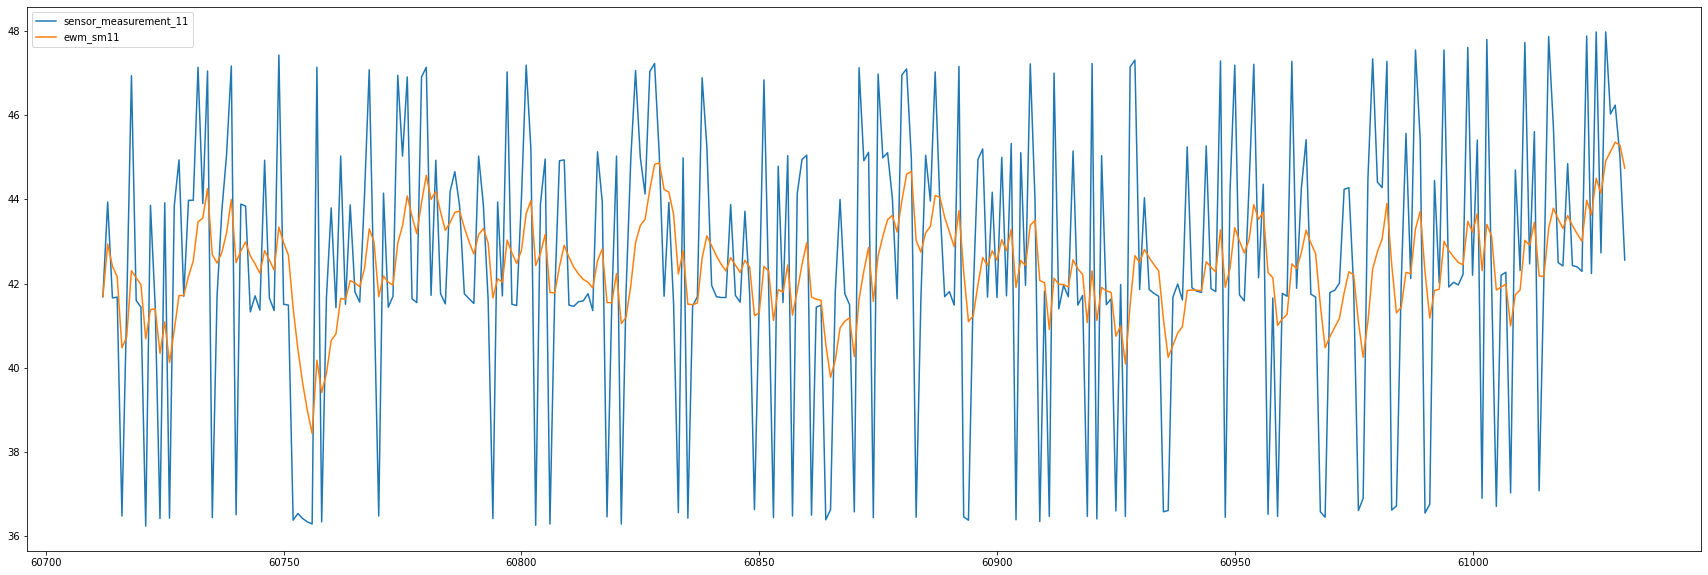

In [39]:
fig, ax = plt.subplots(figsize=(30, 10))
df.loc[(df.filename == 'train_FD004.txt') & (df.unit_number == 1), ['sensor_measurement_11', 'ewm_sm11']].plot(ax=ax)

In [150]:
df[['ewma_' + c for c in sensor_cols]] = df.groupby(['filename', 'unit_number'])[sensor_cols].apply(lambda d: d.ewm(alpha=.2).mean())

In [163]:
x_test

,cycle,op_1,op_2,op_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,...,ewma_sensor_measurement_12,ewma_sensor_measurement_13,ewma_sensor_measurement_14,ewma_sensor_measurement_15,ewma_sensor_measurement_16,ewma_sensor_measurement_17,ewma_sensor_measurement_18,ewma_sensor_measurement_19,ewma_sensor_measurement_20,ewma_sensor_measurement_21
33966,1,20.0064,0.7005,100.0,491.19,606.99,1481.38,1244.70,9.35,13.63,...,316.120000,2388.090000,8061.990000,9.157500,0.020000,364.000000,2324.000000,100.000000,24.500000,14.671500
65237,1,25.0071,0.6200,60.0,462.54,536.12,1259.83,1051.85,7.05,9.02,...,164.490000,2028.270000,7868.750000,10.878300,0.020000,307.000000,1915.000000,84.930000,14.160000,8.612000
80361,1,0.0008,0.0005,100.0,518.67,642.04,1584.20,1398.13,14.62,21.61,...,522.240000,2388.000000,8138.400000,8.420700,0.030000,391.000000,2388.000000,100.000000,38.960000,23.320500
107813,1,0.0018,-0.0001,100.0,518.67,642.19,1585.49,1401.55,14.62,21.61,...,521.920000,2388.000000,8136.140000,8.411100,0.030000,391.000000,2388.000000,100.000000,38.910000,23.489600
33967,2,25.0065,0.6200,60.0,462.54,536.31,1257.76,1032.93,7.05,9.01,...,232.025556,2188.173333,7959.523333,10.092111,0.020000,331.222222,2096.777778,91.627778,18.833333,11.285611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101635,139,20.0065,0.7017,100.0,491.19,607.98,1490.51,1265.98,9.35,13.66,...,305.829646,2384.783735,8084.442496,9.118041,0.026276,362.336446,2295.636961,99.862506,23.366549,14.036026
101636,140,41.9993,0.8400,100.0,445.00,550.30,1360.81,1142.61,3.91,5.72,...,270.697717,2385.372988,8083.195996,9.188713,0.025021,356.469157,2278.909569,99.890004,20.771239,12.509141
101637,141,35.0052,0.8408,100.0,449.44,556.43,1375.70,1148.86,5.48,8.00,...,253.050174,2385.898390,8078.644797,9.238030,0.024017,352.575325,2267.727655,99.912004,19.560992,11.779453
101638,142,35.0032,0.8400,100.0,449.44,556.60,1370.08,1138.94,5.48,8.00,...,238.960139,2386.326712,8075.945838,9.277984,0.023213,349.260260,2258.782124,99.929603,18.574793,11.175702


In [164]:
x_train, x_test = df.loc[is_train, features + ['ewma_' + c for c in sensor_cols]], df.loc[is_test, features + ['ewma_' + c for c in sensor_cols]]
y_train, y_test = df.loc[is_train, 'failure_cycle'],  df.loc[is_test, 'failure_cycle']

In [165]:
from sklearn.ensemble import RandomForestRegressor

In [168]:
cls_log = RandomForestRegressor(n_jobs=-1, n_estimators=40, )
cls_log = cls_log.fit(x_train, np.log1p(y_train))

In [169]:
mean_squared_error(y_train, np.expm1(cls_log.predict(x_train)), squared=False)

17.616184283965097

In [170]:
mean_squared_error(y_test, np.expm1(cls_log.predict(x_test)), squared=False)

46.028908973942585

In [178]:
mean_squared_error(y_test, np.expm1(cls_log.predict(x_test)), squared=False)

45.376309123876766

In [179]:
residuals2 = y_test.values - np.expm1(cls_log.predict(x_test))

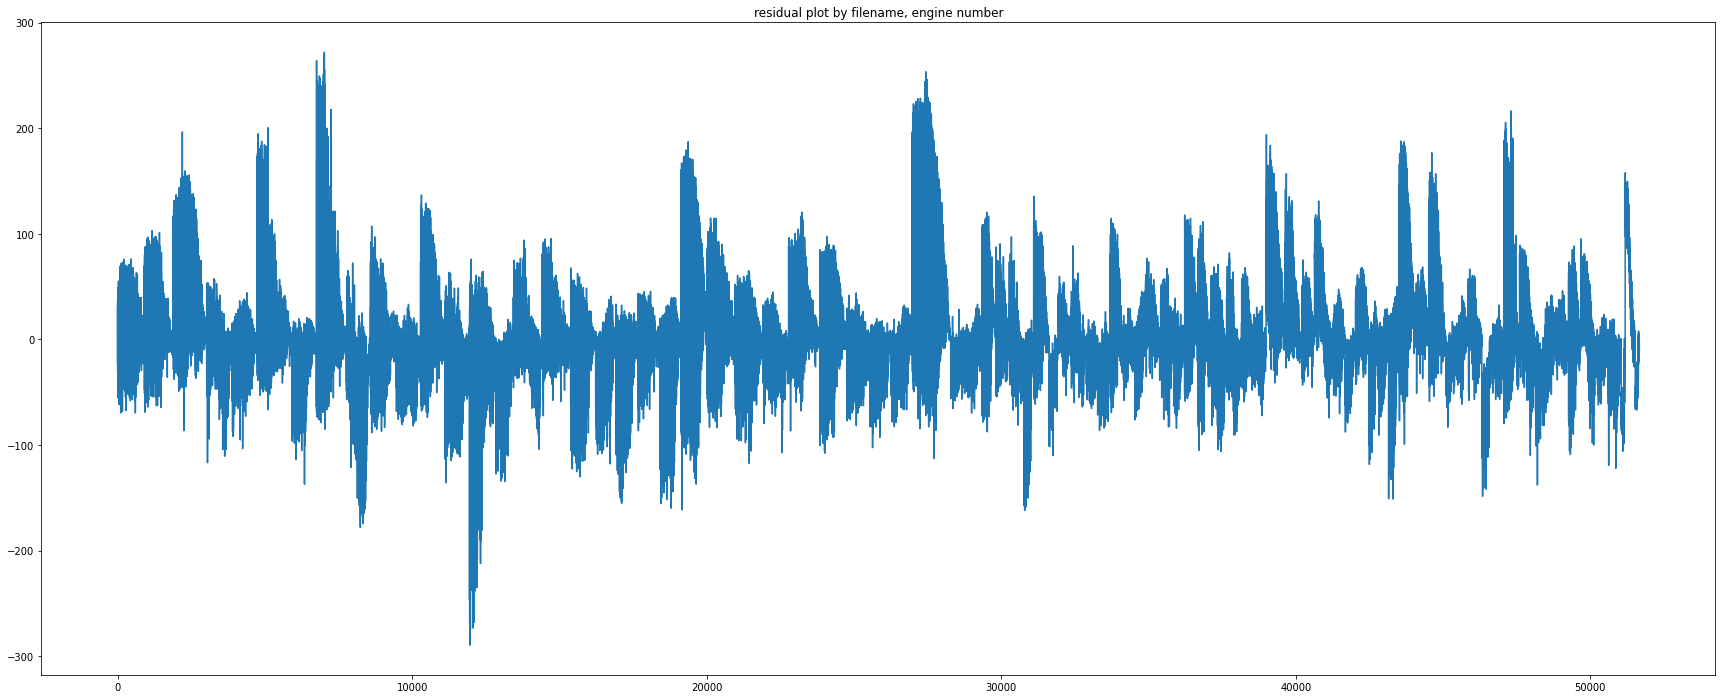

In [180]:
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(residuals2)
_ = ax.set_title('residual plot by filename, engine number')

<BarContainer object of 46 artists>

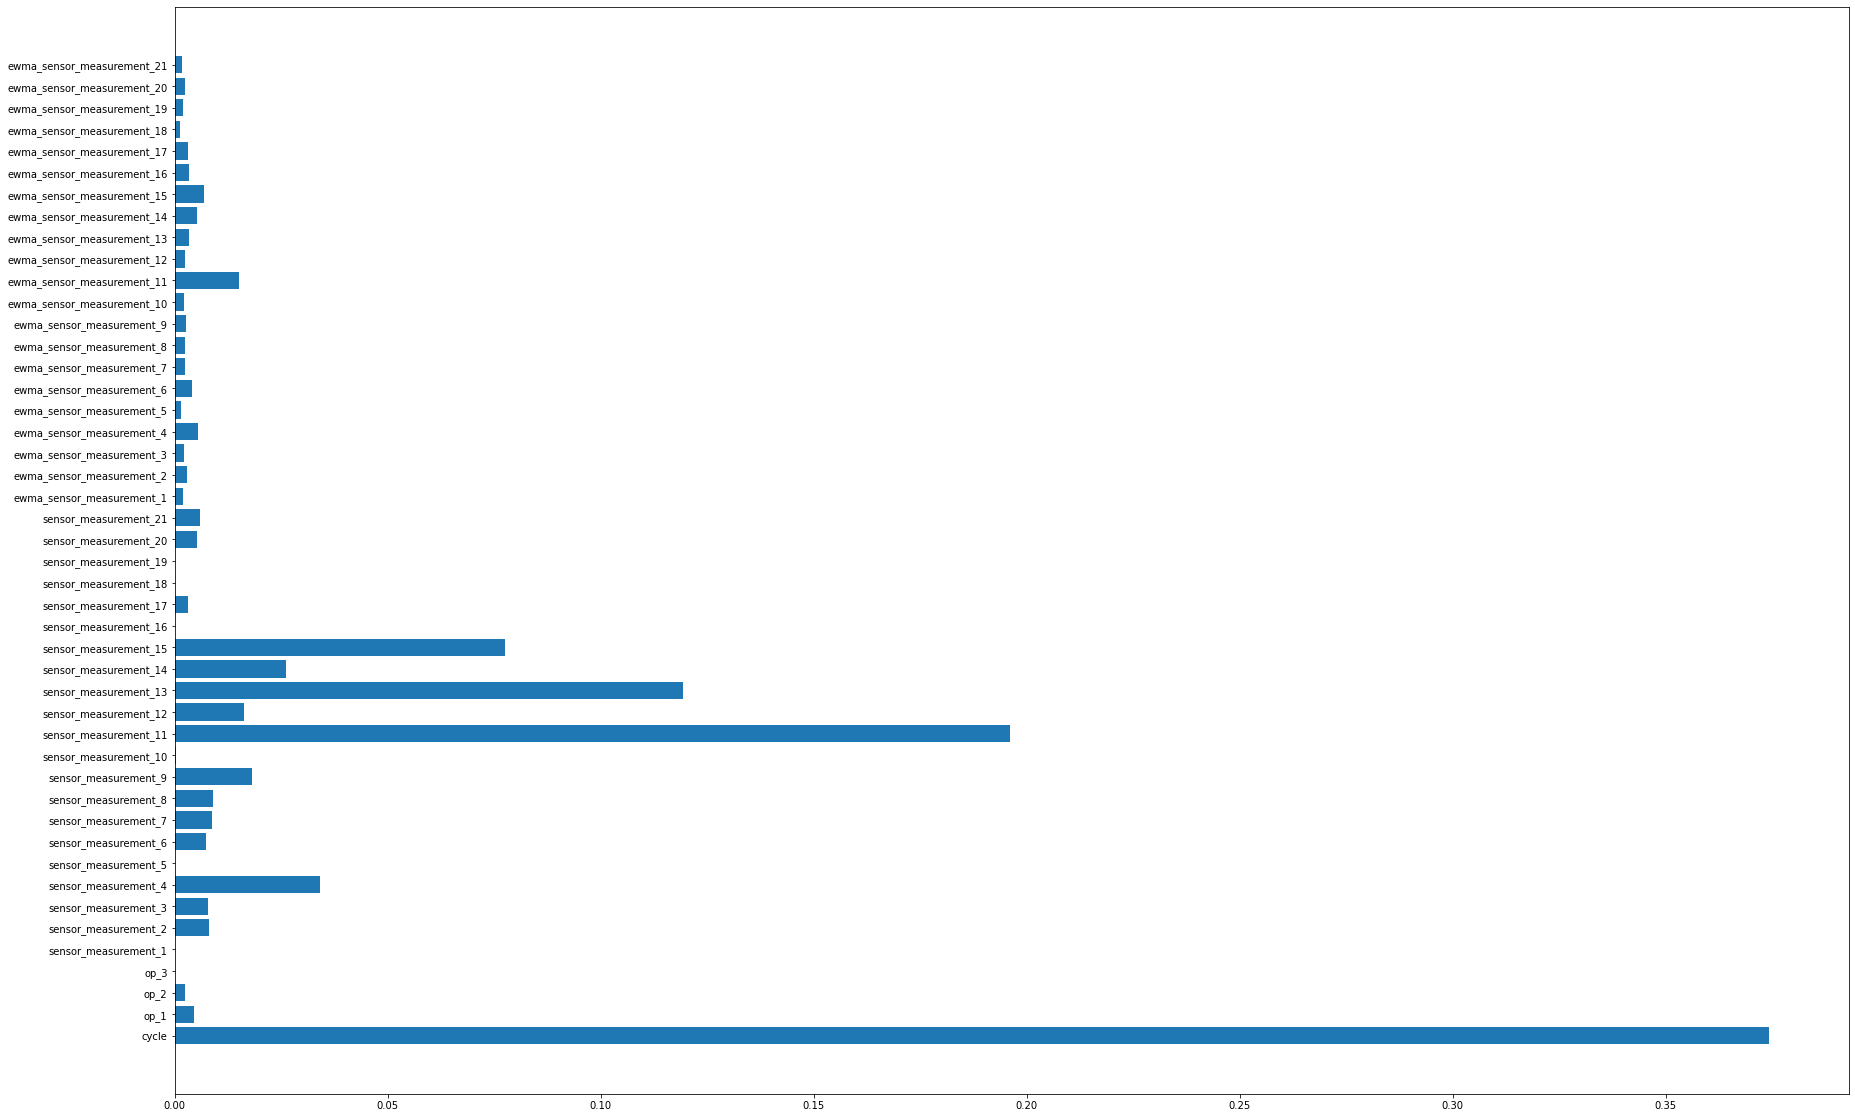

In [171]:
fig, ax = plt.subplots(figsize=(30, 20))
ax.barh( features + ['ewma_' + c for c in sensor_cols], cls_log.feature_importances_)